# Библиотеки и датасет

In [72]:
!pip install shap > None

In [73]:
import pandas as pd
import numpy as np
import shap

In [74]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [75]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [76]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [77]:
from sklearn.model_selection import GridSearchCV

In [78]:
from sklearn.metrics import make_scorer #для создания авторских метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [79]:
df = pd.read_csv('/content/Distr_data.csv')

In [80]:
df.columns.tolist()

['Area/volume',
 'Max/min',
 'org_coating_HAcceptors',
 'org_coating_LogP',
 'common_spin',
 'Eff_anisotropy_const',
 'Magnetic_anisotropy',
 'Magnetocrystalline_anisotropy',
 'Anisotropy constant ',
 'Crystalline',
 'MAE',
 'Curie_temperature',
 'Spehricity',
 'Exchange_constant',
 'Electronegativity core',
 'Space group',
 'Demagnetization_factors',
 'Saturation_magnetization',
 'Coercivity',
 'Remanence_magnetization',
 'Interdomain_coupling',
 'M_magnetic_susceptibility']

# Обучение и сравнение моделей

In [81]:
X = df.drop('Curie_temperature', axis=1)  #Без целевой переменной
y = df['Curie_temperature']  #Целевая переменная

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# Модели
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    BaggingRegressor(n_estimators=100, random_state=42),
    SVR(),
    KNeighborsRegressor(n_neighbors=100),
    MLPRegressor(max_iter=500)]

Используем кросвалидацию

In [84]:
# Сохраняем результаты в список
results = []

# Нужно оценить каждую модель
for model in models:
    model.fit(X_train, y_train)  # обучение модели на тренировочном
    y_pred = model.predict(X_test)  # предсказание

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model.__class__.__name__,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    })

Создаем DataFrame для удобного вывода

In [85]:
results_df = pd.DataFrame(results)
print(results_df)

                        Model       MSE      RMSE        R2
0            LinearRegression  0.003713  0.060938  0.642673
1                       Ridge  0.003961  0.062934  0.618872
2                       Lasso  0.010425  0.102104 -0.003179
3                  ElasticNet  0.010425  0.102104 -0.003179
4       RandomForestRegressor  0.000749  0.027369  0.927921
5   GradientBoostingRegressor  0.000732  0.027047  0.929607
6           AdaBoostRegressor  0.003768  0.061381  0.637459
7            BaggingRegressor  0.000665  0.025790  0.935997
8                         SVR  0.007111  0.084324  0.315775
9         KNeighborsRegressor  0.009992  0.099961  0.038479
10               MLPRegressor  0.005781  0.076035  0.443688


Как видно по значениям MSE наименьшее у моделей GradientBoosting (0,000732) и RandomForest (0,000749), а это значит это лучшие типы моделей для этой задачи. RMSE - меньше у модели GradientBoost. R2 ближе к 1 у GradientBoosting.

Лучшие модели:


1.   RandomForest
2.   GradientBoosting

R2 (Коэффициент детерминации):

RandomForestRegressor: 0.927921
GradientBoostingRegressor: 0.929607
R2 измеряет объясненную вариацию в данных. Значения R2 близки к 1, что говорит о том, что модели хорошо объясняют вариацию в данных. В данном случае обе модели достигли высокого значения R2, что указывает на их хорошую предсказательную способность.

# Гиперпараметры

Подберём гиперпараметры с помощью GridSearchCV, чтобы улучшить предсказания моделей, и проверим это на тестовой выборке

In [86]:
rf_regressor = RandomForestRegressor()
gradient_boosting_regressor = GradientBoostingRegressor()

param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20]
}

param_grid_gradient_boosting = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

In [87]:
# Подбор гиперпараметров для RandomForest
grid_rf = GridSearchCV(rf_regressor, param_grid_rf, scoring='neg_mean_squared_error', cv=10)
grid_rf.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
best_rf_model = grid_rf.best_estimator_
best_rf_params = grid_rf.best_params_
print(f'Best RandomForest Hyperparameters: {best_rf_params}')

# Подбор гиперпараметров для GradientBoosting
grid_gradient_boosting = GridSearchCV(gradient_boosting_regressor, param_grid_gradient_boosting, scoring='neg_mean_squared_error', cv=10)
grid_gradient_boosting.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
best_gradient_boosting_model = grid_gradient_boosting.best_estimator_
best_gradient_boosting_params = grid_gradient_boosting.best_params_
print(f'Best GradientBoosting Hyperparameters: {best_gradient_boosting_params}')

# Оценка моделей на тестовом наборе
y_pred_rf = best_rf_model.predict(X_test)
y_pred_gradient_boosting = best_gradient_boosting_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gradient_boosting = mean_squared_error(y_test, y_pred_gradient_boosting)

print(f'RandomForest Test MSE: {mse_rf:.4f}')
print(f'GradientBoosting Test MSE: {mse_gradient_boosting:.4f}')

Best RandomForest Hyperparameters: {'max_depth': 10, 'n_estimators': 100}
Best GradientBoosting Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
RandomForest Test MSE: 0.0009
GradientBoosting Test MSE: 0.0003


# Виузализация предсказания

Пример для построениия графиков предсказния

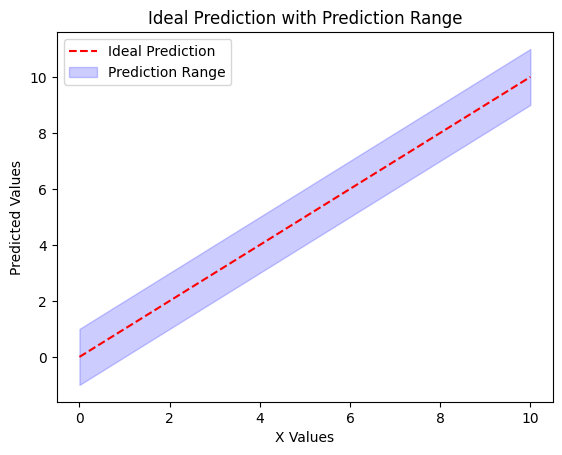

In [88]:
# Создание данных для примера
x_values = np.linspace(0, 10, 100)
ideal_line = x_values  # Линия идеального предсказания
#Границей разброса может быть стандартное отклонение
lower_bound = ideal_line - 1  # Произвольная нижняя граница разброса
upper_bound = ideal_line + 1  # Произвольная верхняя граница разброса

# Создание графика
plt.plot(x_values, ideal_line, label='Ideal Prediction', linestyle='--', color='red')
plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2, label='Prediction Range')

# Добавление меток и легенды
plt.title('Ideal Prediction with Prediction Range')
plt.xlabel('X Values')
plt.ylabel('Predicted Values')
plt.legend()

# Отображение графика
plt.show()

Сначаала посмотрим на различие в предсказании этих двух моделей с помощью общего графика без линий разброса или линии идельного предсказания

In [89]:
# Посчитать RMSE and R2 для RandomForest
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Подсчет RMSE и R2 для GradientBoosting
rmse_gradient_boosting = np.sqrt(mse_gradient_boosting)
r2_gradient_boosting = r2_score(y_test, y_pred_gradient_boosting)

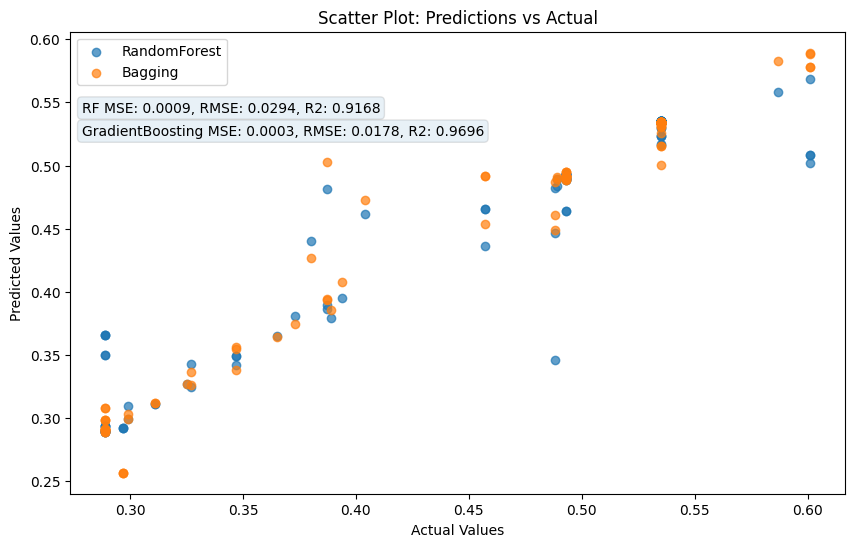

In [90]:
# Создание графика
plt.figure(figsize=(10, 6))

# Scatter plot для RandomForest
plt.scatter(y_test, y_pred_rf, label='RandomForest', alpha=0.7)

# Scatter plot для GradientBoosting
plt.scatter(y_test, y_pred_gradient_boosting, label='Bagging', alpha=0.7)

# Добавление меток и легенды
plt.title('Scatter Plot: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Добавление текста с метриками в углу графика
text_rf = f'RF MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}'
text_bagging = f'GradientBoosting MSE: {mse_gradient_boosting:.4f}, RMSE: {rmse_gradient_boosting:.4f}, R2: {r2_gradient_boosting:.4f}'

plt.text(0.015, 0.85, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
plt.text(0.015, 0.80, text_bagging, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Отображение графика
plt.show()

Видно, что модели имеют очень в разброс значений

Посчитаем стандартное отклонение моделей

In [91]:
# Рассчитываем стандартное отклонение
std_rf = np.std(y_pred_rf)
std_gradient_boosting = np.std(y_pred_gradient_boosting)
print(f'RandomForest Std: {std_rf:.4f}')
print(f'GradientBoosting Test Std: {std_gradient_boosting:.4f}')

RandomForest Std: 0.0930
GradientBoosting Test Std: 0.1001


Сделаем отдельные графики для каждой модели, добавим линию идельного предсказания и разброса на основе отклонения от фактических и предсказанных

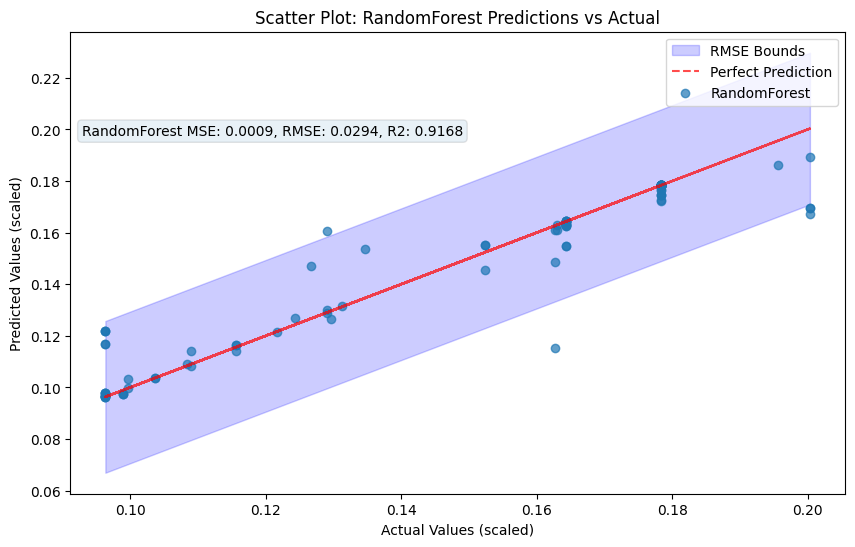

In [92]:
# Scatter plot для RandomForest
text_rf = f'RandomForest MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}'
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y
y_test_scaled_rf = y_test / 3
y_pred_rf_scaled = y_pred_rf / 3

# Линия разброса от линии идеального предсказания
lower_bound_rf = np.sort(y_test_scaled_rf - rmse_rf)
upper_bound_rf = np.sort(y_test_scaled_rf + rmse_rf)
plt.fill_between(np.sort(y_test_scaled_rf), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled_rf, y_test_scaled_rf, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled_rf, y_pred_rf_scaled, label='RandomForest', alpha=0.7)

# Добавление текста с метриками
plt.text(0.015, 0.8, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: RandomForest Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

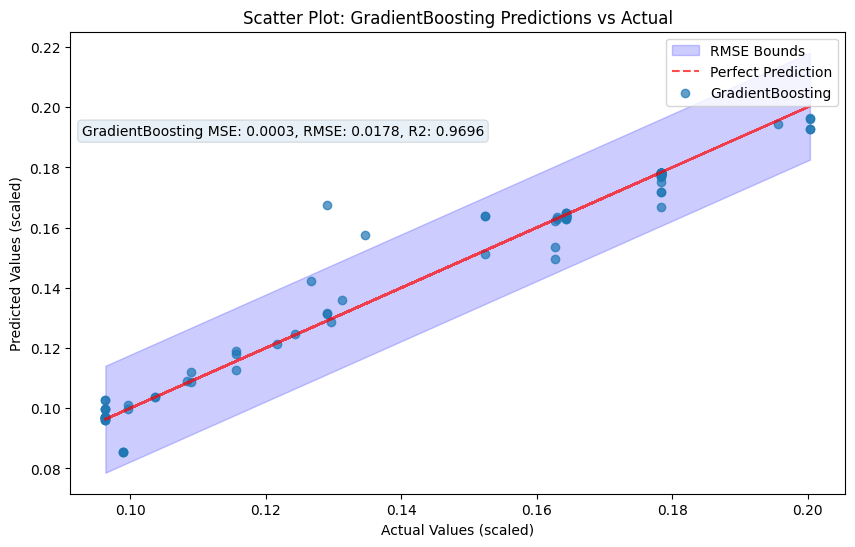

In [93]:
# График рассеивания для Bagging
text_bagging = f'GradientBoosting MSE: {mse_gradient_boosting:.4f}, RMSE: {rmse_gradient_boosting:.4f}, R2: {r2_gradient_boosting:.4f}'
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y
y_test_scaled = y_test / 3
y_pred_bagging_scaled = y_pred_gradient_boosting / 3

# Линия разброса от линии идеального предсказания
lower_bound = np.sort(y_test_scaled - rmse_gradient_boosting)
upper_bound = np.sort(y_test_scaled + rmse_gradient_boosting)
plt.fill_between(np.sort(y_test_scaled), lower_bound, upper_bound, color='blue', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled, y_test_scaled, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled, y_pred_bagging_scaled, label='GradientBoosting', alpha=0.7)

# Добавление текста с метриками
plt.text(0.015, 0.8, text_bagging, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: GradientBoosting Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

# Проверим модели на переобучение

Посмотрим на производительность обучения и разницу визулизаций тестовой и тренировочной выборки

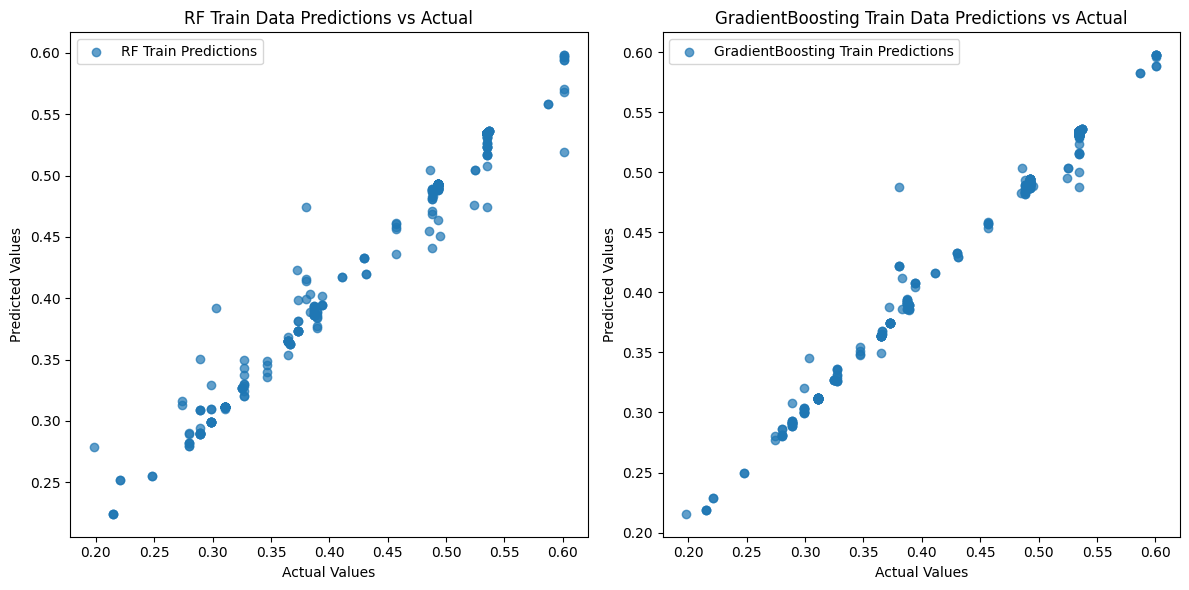

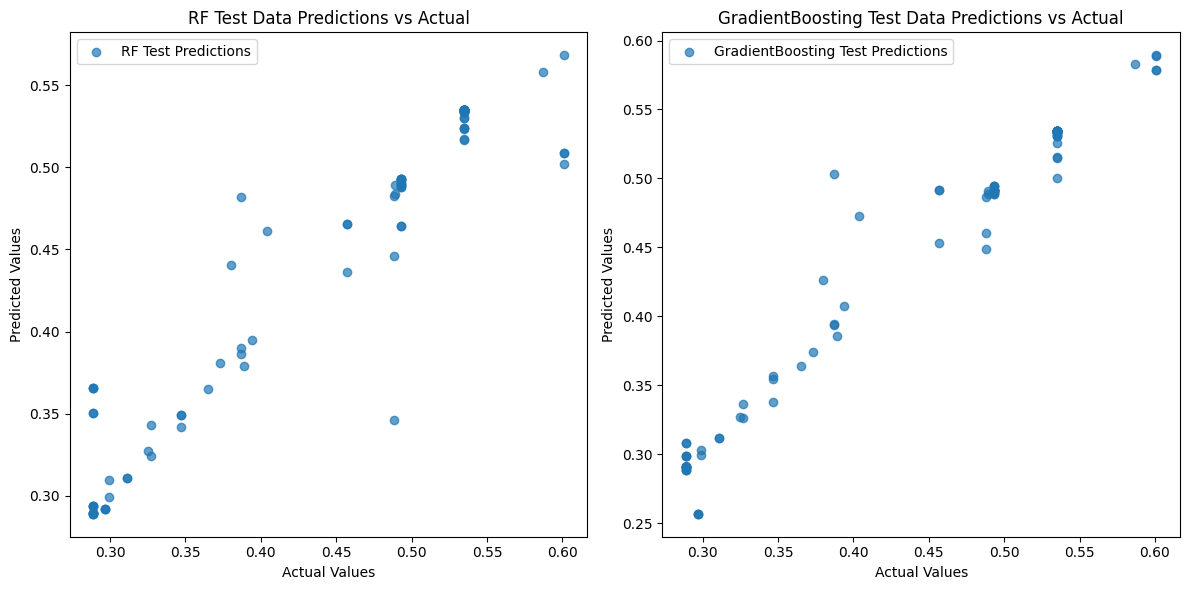

In [94]:
# Для RandomForest
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Для GradientBoosting
y_train_pred_bagging = best_gradient_boosting_model.predict(X_train)
y_test_pred_bagging = best_gradient_boosting_model.predict(X_test)

# Визуализация для тренировочных данных
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, label='RF Train Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RF Train Data Predictions vs Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_pred_bagging, label='GradientBoosting Train Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GradientBoosting Train Data Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация для тестовых данных
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_rf, label='RF Test Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RF Test Data Predictions vs Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_bagging, label='GradientBoosting Test Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GradientBoosting Test Data Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

Как видно все предсказания на графиках выше похожи на диагональные прямые, это хороший знак. Как видно на в графиках test появляются выбросы в районе 0

In [95]:
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

train_accuracy_bagging = best_gradient_boosting_model.score(X_train, y_train)
test_accuracy_bagging = best_gradient_boosting_model.score(X_test, y_test)

print(f'RF Train Accuracy: {train_accuracy_rf:.4f}, Test Accuracy: {test_accuracy_rf:.4f}')
print(f'GradientBoosting Train Accuracy: {train_accuracy_bagging:.4f}, Test Accuracy: {test_accuracy_bagging:.4f}')

RF Train Accuracy: 0.9825, Test Accuracy: 0.9168
GradientBoosting Train Accuracy: 0.9923, Test Accuracy: 0.9696


Оба метода (Random Forest и GradientBoosting) показывают высокую точность как на обучающем, так и на тестовом наборе данных. У обеих моделей высокая точность на обучающем наборе, что может свидетельствовать о хорошей способности моделей "запоминать" обучающие данные.
Точность на тестовом наборе Gradient Boosting выше, чем у Random Forest, что может указывать на то, что Gradient Boosting лучше справляется с обобщением на новые данные.

RandomForestRegressor достаточно хорошо объясняет вариацию в тренировочных данных (R2 = 0.9825), но немного хуже справляется с объяснением вариации в тестовых данных (R2 = 0.9168). Возможно, есть некоторое переобучение (overfitting) модели на тренировочных данных, и она несколько теряет обобщающую способность на новых данных.

В случае GradientBoostingRegressor, модель также хорошо объясняет вариацию в тренировочных данных (R2 = 0.9923) и лучше справляется с объяснением вариации в тестовых данных по сравнению с RandomForestRegressor (R2 = 0.9696). Это может говорить о том, что GradientBoostingRegressor более устойчив к переобучению.

# Интерпретация

Еще раз обучим модели, чтобы иметь возможность обратиться именно к ним

In [96]:
X = df.drop('Curie_temperature', axis=1)
y = df['Curie_temperature']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение RandomForest с заданными гиперпараметрами
rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# Обучение GradientBoosting с заданными гиперпараметрами
gradient_boosting_params = {'n_estimators': 50, 'learning_rate': 0.1, 'max_features': 0.8, 'subsample': 1.0}
gradient_boosting_model = GradientBoostingRegressor(**gradient_boosting_params)
gradient_boosting_model.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_rf = rf_model.predict(X_test)
y_pred_gradient_boosting = gradient_boosting_model.predict(X_test)

Посмотрим какие данные вносят больший вклад в предсказание с помощью SHAP диаграммы

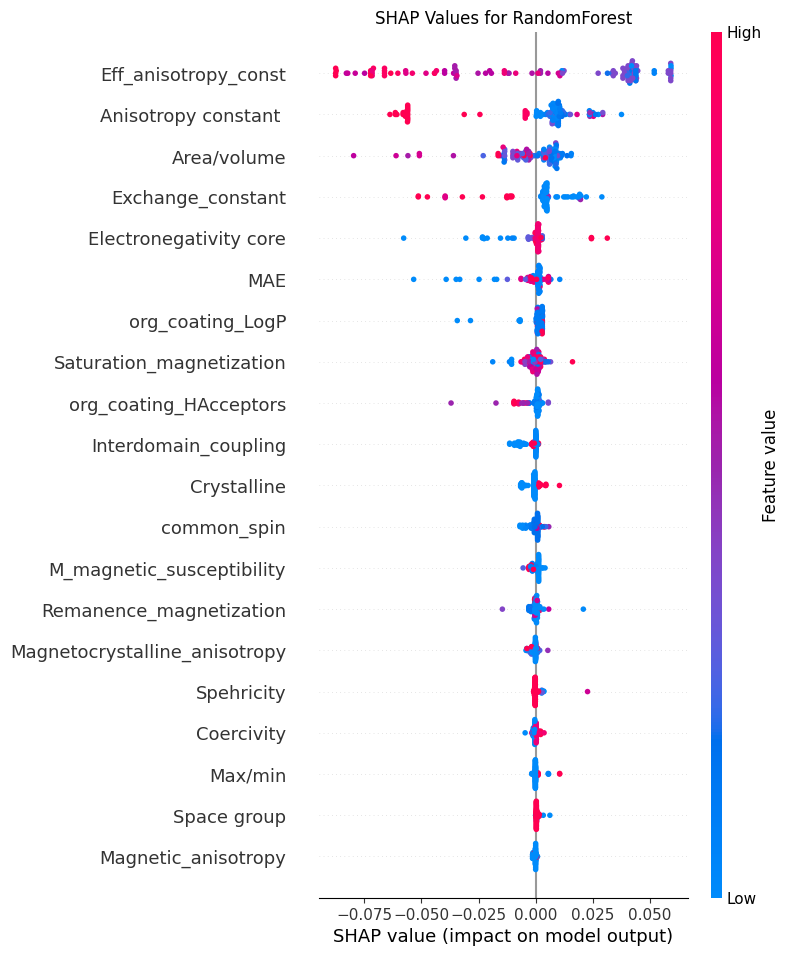

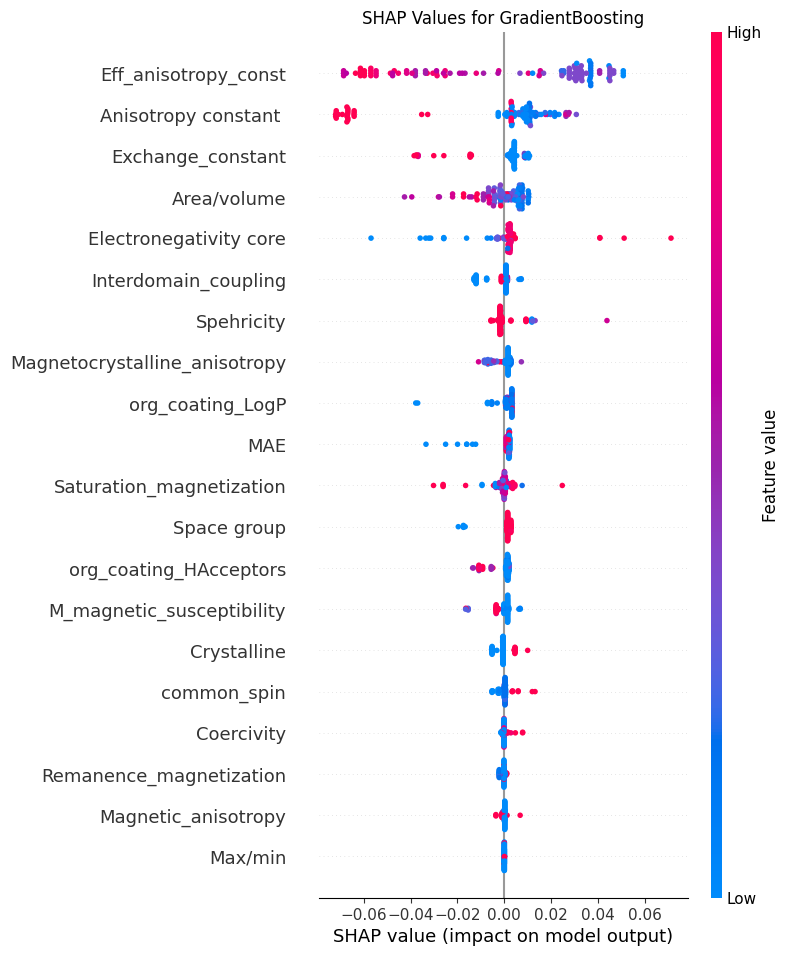

In [97]:
import shap

# Создание explainer'ов
rf_explainer = shap.TreeExplainer(rf_model)
gradient_boosting_explainer = shap.TreeExplainer(gradient_boosting_model)

# Расчет SHAP-значений для тестового набора данных
shap_values_rf = rf_explainer.shap_values(X_test)
shap_values_gradient_boosting = gradient_boosting_explainer.shap_values(X_test)

# Построение SHAP-диаграммы для RandomForest
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for RandomForest')
plt.show()

# Построение SHAP-диаграммы для GradientBoosting
shap.summary_plot(shap_values_gradient_boosting, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for GradientBoosting')
plt.show()